## Import Dependencies

In [3]:
import pandas as pd
import numpy as np

#For plots
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

#For reading and ploting shape file
import geopandas as gpd
from geopandas import GeoSeries

## Read relevant file:

### Read Event Log CSV and convert timestamp accordingly

In [4]:
df_eventlog=pd.read_csv('Dataset/event_log.csv', sep='\t')
df_eventlog["date_time2"] = pd.to_datetime(df_eventlog["date_time"], unit='s')
df_eventlog["date_time2"]=df_eventlog["date_time2"].apply(lambda x:x.replace(second=0))
df_eventlog["day"] = df_eventlog["date_time2"].apply(lambda x: x.day)
df_eventlog["month"] = df_eventlog["date_time2"].apply(lambda x: x.month)
df_eventlog["hm"] =  df_eventlog["date_time2"].apply(lambda x: int(str(x.hour).zfill(2) + str(x.minute).zfill(2)))
df_eventlog["date"] = df_eventlog["date_time2"].apply(lambda x: int(str(x.month).zfill(2) + str(x.day).zfill(2)))
df_eventlog.head()


,customer_id,grid_id,date_time,date_time2,day,month,hm,date
0,h092861261790079492,166839.0,1.563521e+09,2019-07-19 07:30:00,19,7,730,719
1,k438071835109624353,168252.0,1.563521e+09,2019-07-19 07:31:00,19,7,731,719
2,1481701602817207678,179477.0,1.563522e+09,2019-07-19 07:36:00,19,7,736,719
3,5368934103184310830,170354.0,1.563522e+09,2019-07-19 07:36:00,19,7,736,719
4,u832408493379095560,175968.0,1.563522e+09,2019-07-19 07:39:00,19,7,739,719


### Read Shape file with geopandas

In [5]:
shape = gpd.read_file("Dataset/shape/shape.shp")
print(shape)

      grid_id                                           geometry
0    159117.0  POLYGON ((101.6391197006636 2.88681056372882, ...
1    159118.0  POLYGON ((101.6413674050592 2.886291436419907,...
2    159119.0  POLYGON ((101.6436151094493 2.88655105061499, ...
3    159120.0  POLYGON ((101.6458628138338 2.886810664809432,...
4    159121.0  POLYGON ((101.6481105182128 2.887070279003228,...
..        ...                                                ...
569  178777.0  POLYGON ((101.6458628138338 2.950223937039077,...
570  178778.0  POLYGON ((101.6481105182128 2.949678785067002,...
571  178779.0  POLYGON ((101.6503582225862 2.949133633096279,...
572  179476.0  POLYGON ((101.6398004646444 2.950889524771795,...
573  179477.0  POLYGON ((101.6413674050592 2.951314240987283,...

[574 rows x 2 columns]


### Define grid_id in each of the six routes specified

In [6]:
route1=[173860.0,173861.0,173159.0,173160.0,173161.0,172459.0,172460.0,172461.0,172462.0,172463.0,172464.0] 
route2= [173860.0, 173859.0,173157.0,172455.0,171753.0,171051.0,170349.0,169647.0,168945.0,168243.0,167541.0, 166839.0,166137.0,165435.0]
route3= [165435.0,165436.0,165437.0,165438.0,166140.0,166141.0,166843.0,166844.0,166845.0,166846.0,166847.0 ,166848.0,166849.0]
route4= [166847.0,167549.0,167550.0,168252.0,168954.0,169656.0,170358.0,171060.0,171762.0,172464.0] 
route5= [170361.0,170360.0,171061.0,170359.0,170358.0,170357.0,170356.0,170355.0,169653.0,169652.0,169651.0, 170353.0,170352.0,170351.0,170350.0,170349.0,170348.0,169645.0,169644.0] 
route6=  [166844.0,167546.0,168248.0,168247.0,168949.0,169651.0,170353.0,171055.0,171757.0,171756.0,172458.0,173160]

## Data Manipulation and Transformation

### Specify Date in variable below for visualization

In [7]:
date=719
df_filtered=df_eventlog[(df_eventlog['date'] == date) & ((df_eventlog['hm'] >= 1200) &(df_eventlog['hm'] <= 1400))]
df_filtered.head()

,customer_id,grid_id,date_time,date_time2,day,month,hm,date
17407,8985523466505351729,171051.0,1.563538e+09,2019-07-19 12:00:00,19,7,1200,719
17408,h721406678918682761,168249.0,1.563538e+09,2019-07-19 12:00:00,19,7,1200,719
17409,z817363553362291439,168252.0,1.563538e+09,2019-07-19 12:00:00,19,7,1200,719
17410,8670963549539689956,169644.0,1.563538e+09,2019-07-19 12:00:00,19,7,1200,719
17411,h305083402010947389,173159.0,1.563538e+09,2019-07-19 12:00:00,19,7,1200,719


### Filter Dataset for customer that are static on the same grid_id for more than one timeframe. Time frame here is 1 minute

In [18]:
static={}
static['grid_id']=[]
static['date_time2']=[]
static['count']=[]

for grid in (route1+route2+route3+route4+route5+route6):
    '''Store customer id into a list (grid_pool_n0) for storing and check it against the customer id in the same grid on the next time frame'''
    gridpool_n0=[]
    data=df_filtered[df_filtered['grid_id']==grid]
    for i, time in enumerate(sorted(list(df_filtered['date_time2'].unique()))):
        if i ==0:
            gridpool_n0=data['customer_id'][data['date_time2']==time].tolist()
        
        '''This counts the number of static customer id on the same grid for more then one timeframe'''
        count=data['customer_id'].isin(gridpool_n0).sum()
        gridpool_n0=data['customer_id'][data['date_time2']==time].tolist()
        static['grid_id'].append(grid)
        static['date_time2'].append(time)
        static['count'].append(count)
df_static=pd.DataFrame(static)
df_static.head()

,grid_id,date_time2,count
0,173860.0,2019-07-19 12:00:00,5
1,173860.0,2019-07-19 12:01:00,5
2,173860.0,2019-07-19 12:02:00,1
3,173860.0,2019-07-19 12:03:00,1
4,173860.0,2019-07-19 12:04:00,1


### Overlap the static customer plot over time on CyberJaya Map

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:413: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


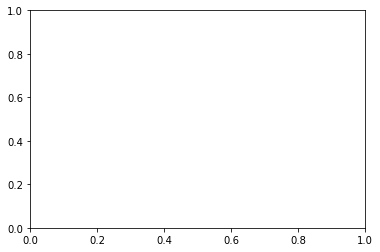

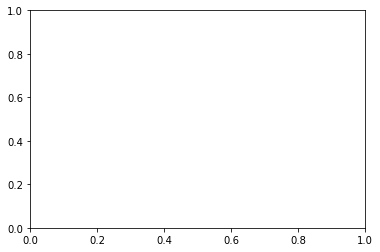

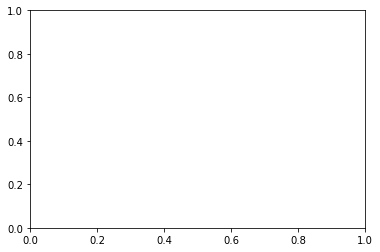

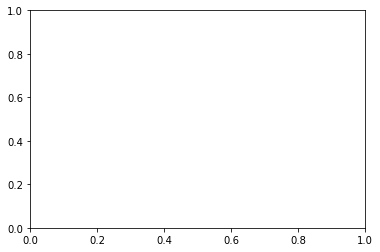

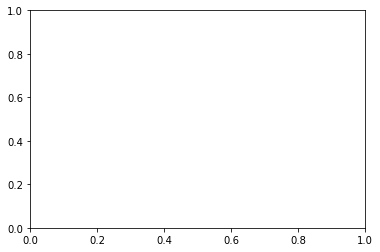

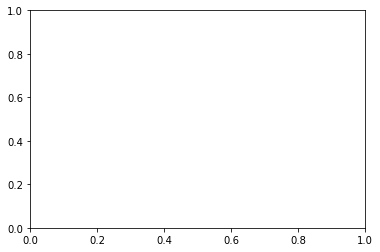

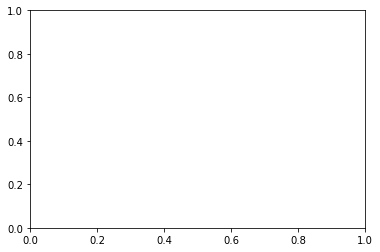

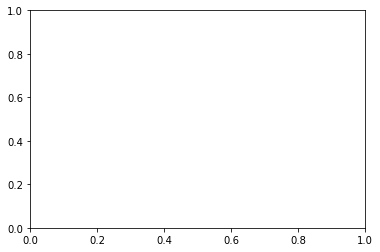

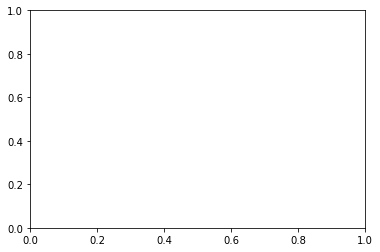

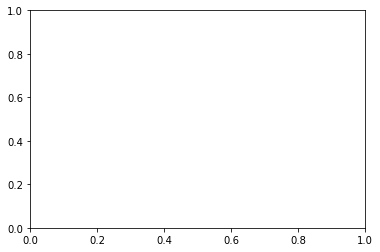

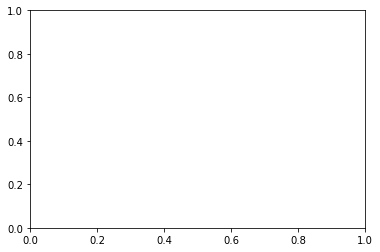

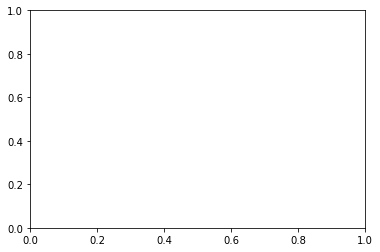

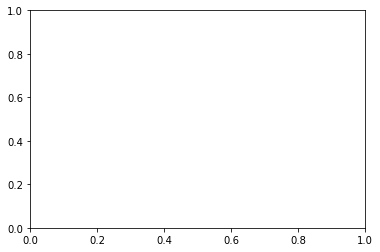

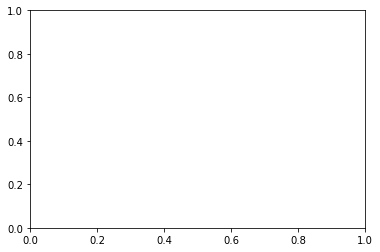

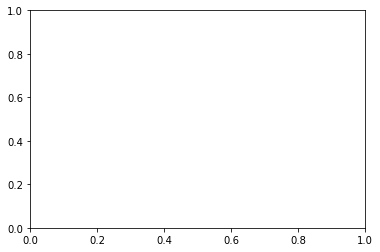

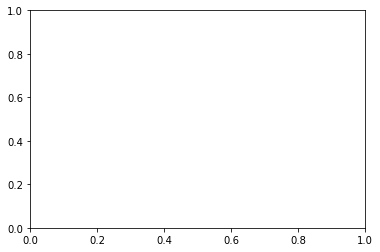

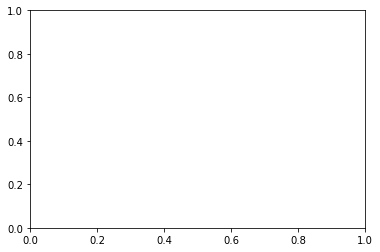

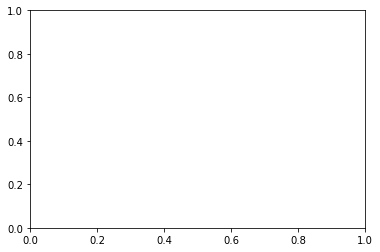

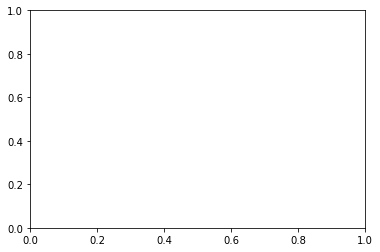

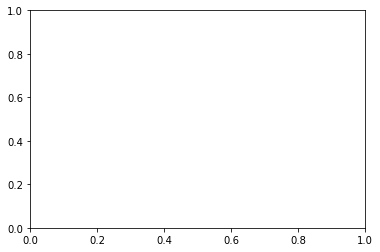

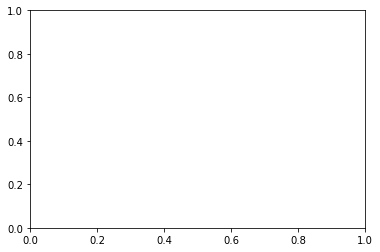

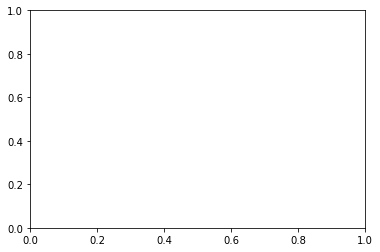

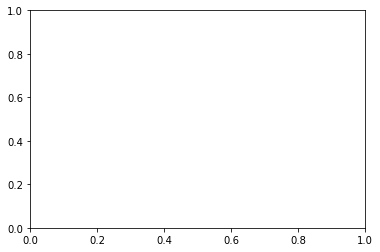

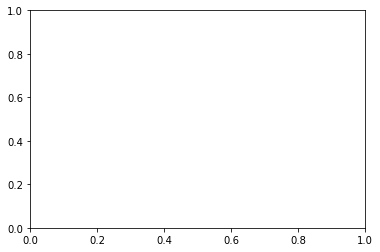

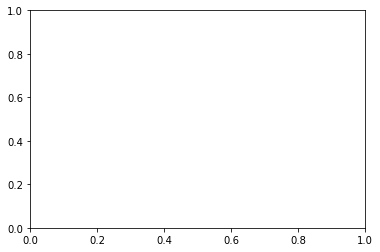

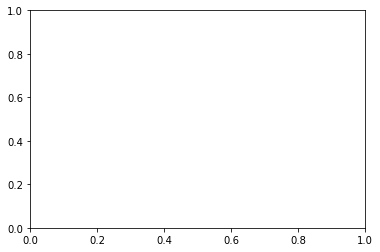

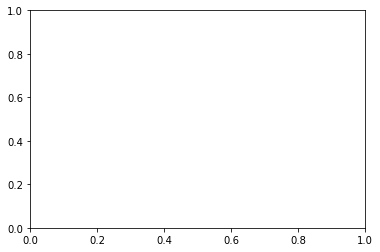

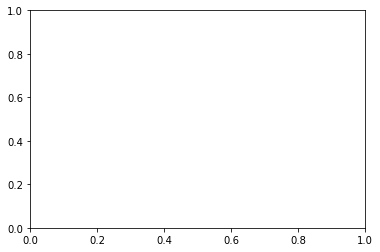

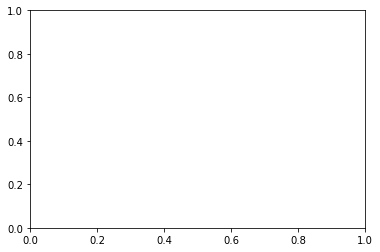

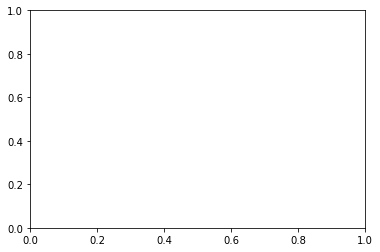

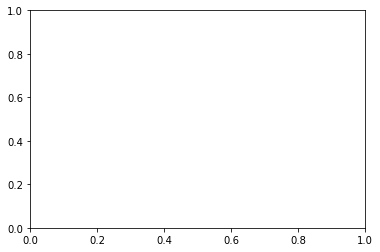

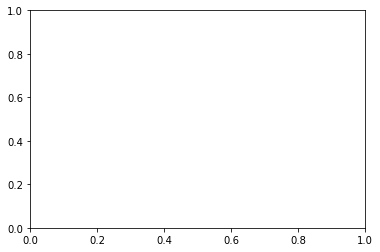

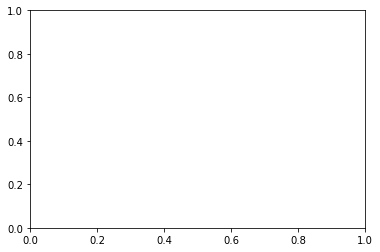

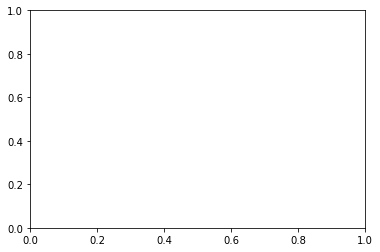

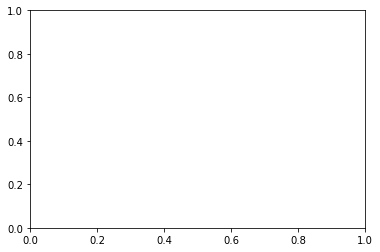

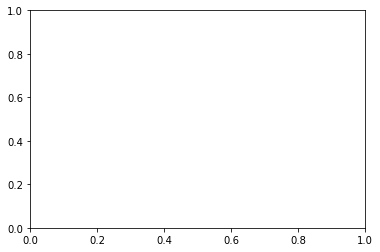

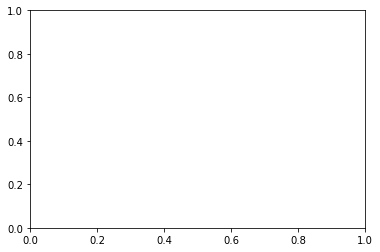

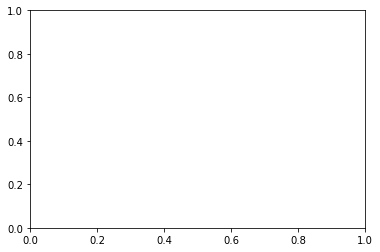

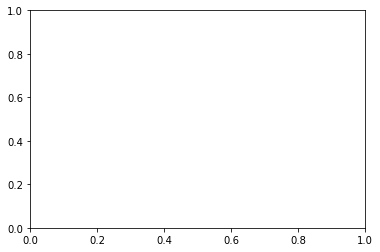

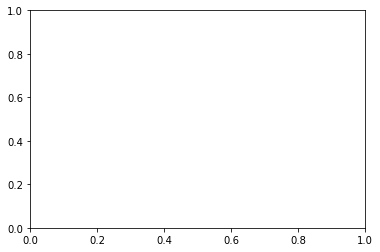

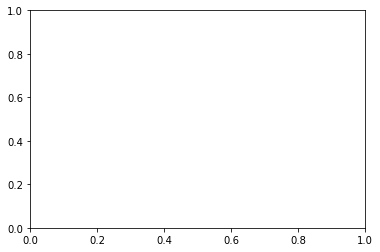

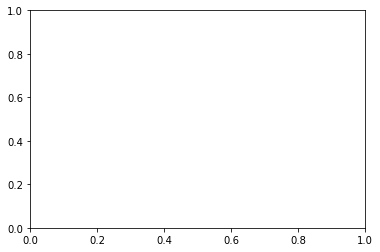

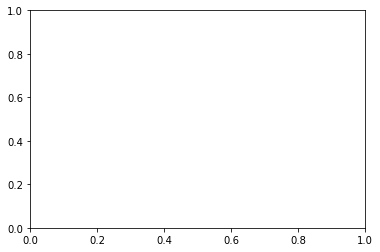

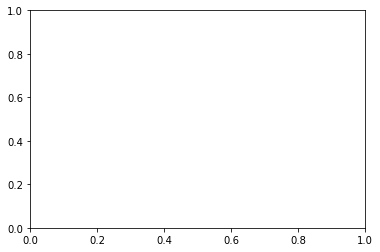

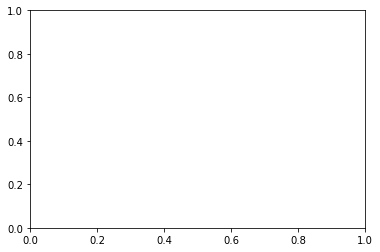

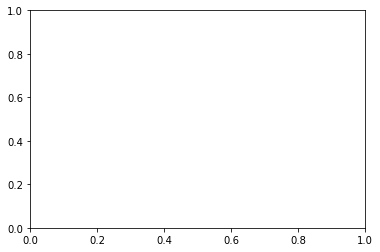

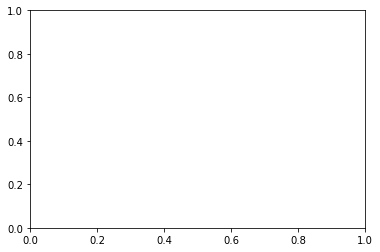

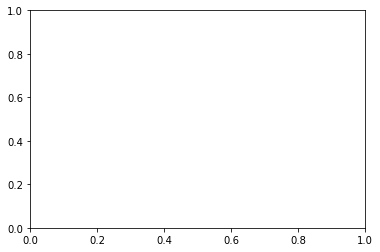

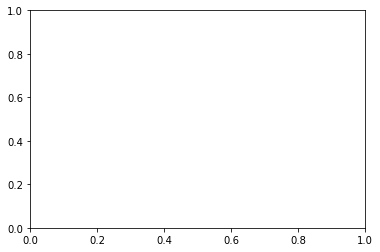

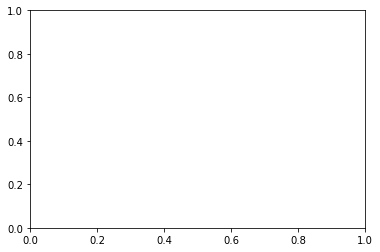

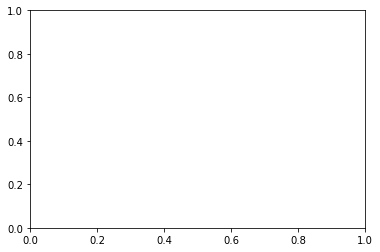

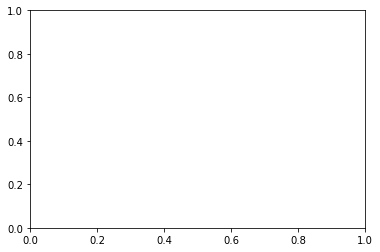

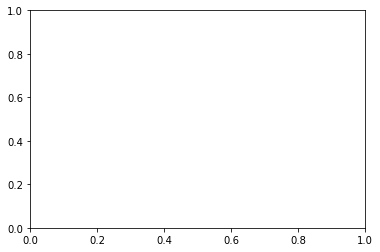

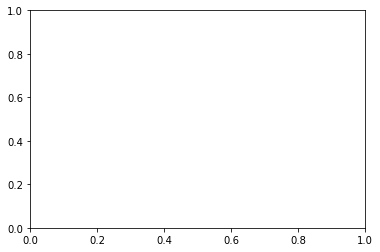

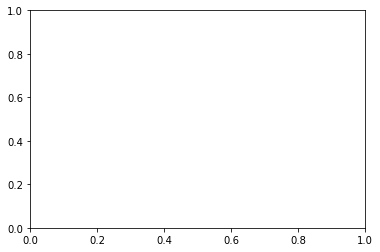

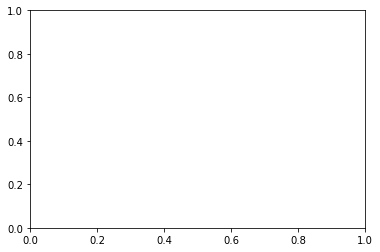

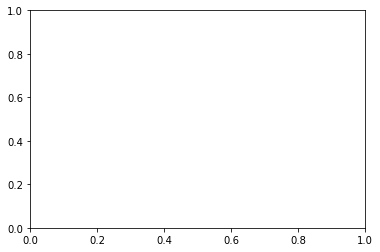

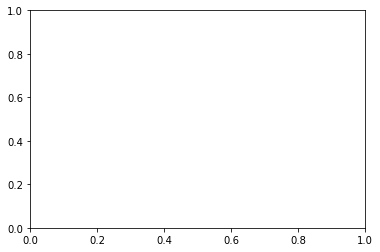

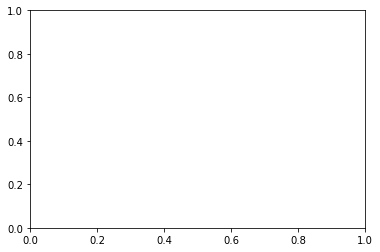

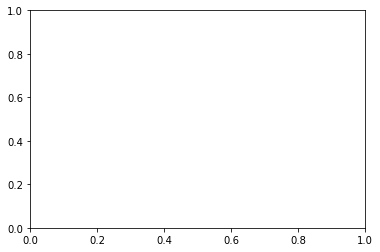

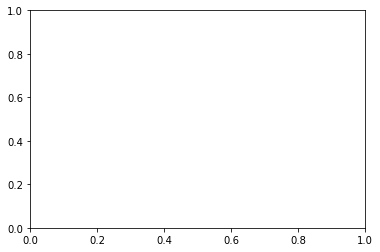

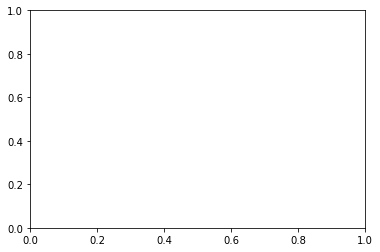

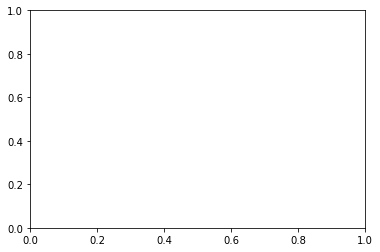

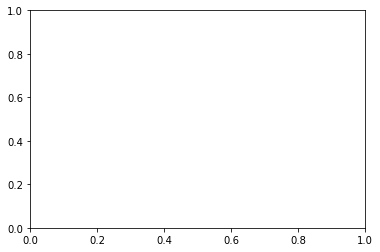

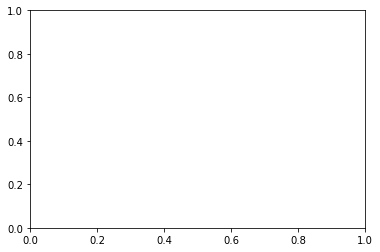

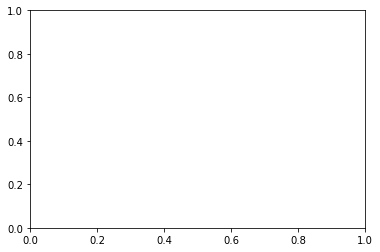

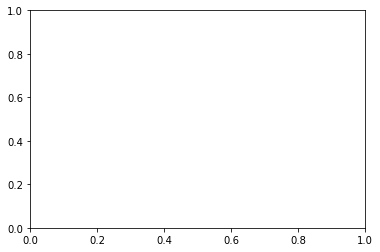

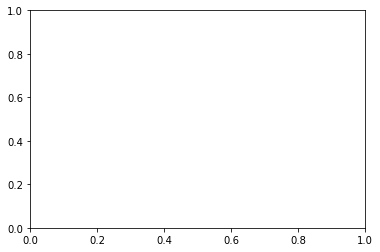

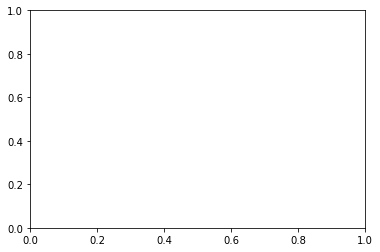

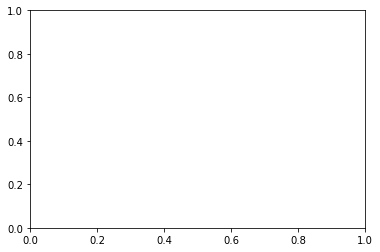

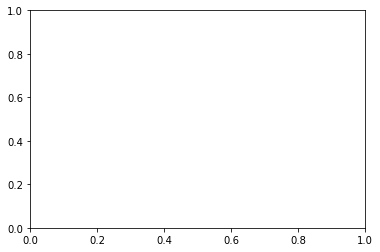

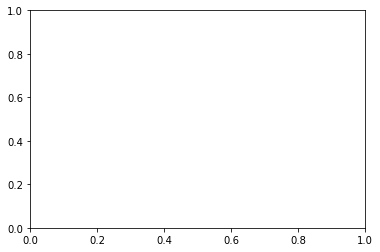

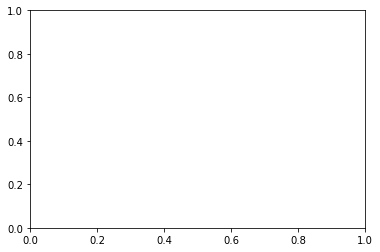

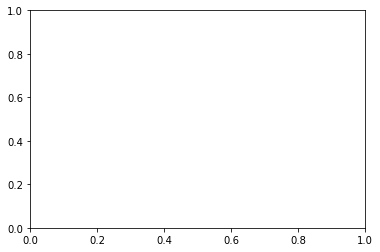

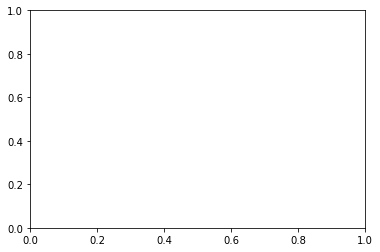

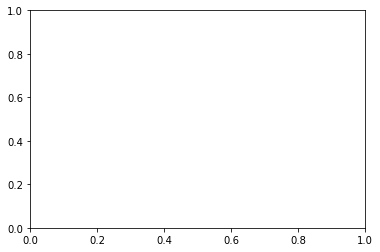

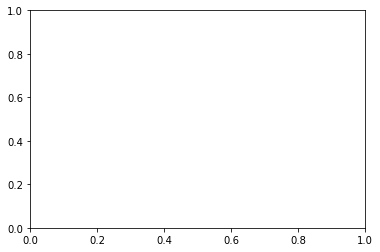

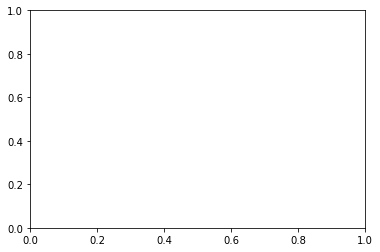

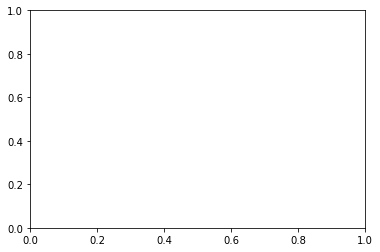

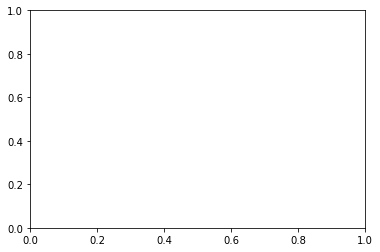

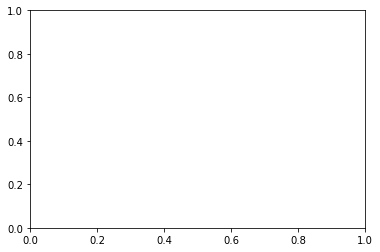

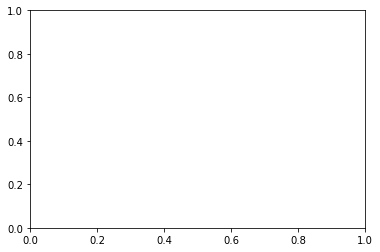

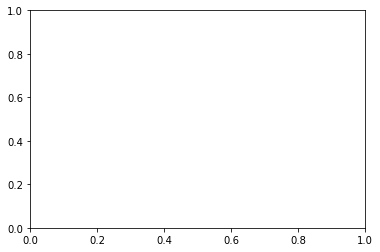

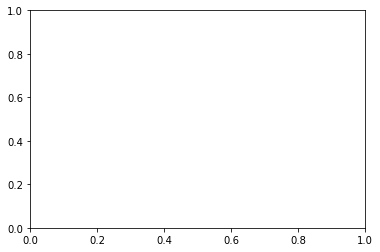

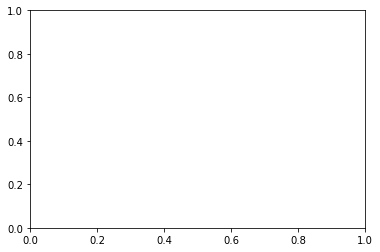

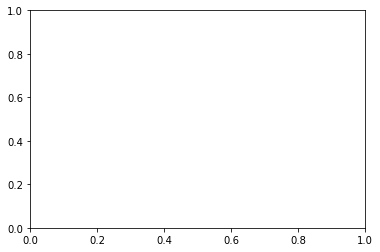

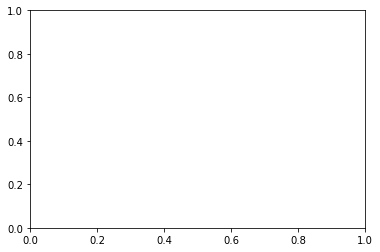

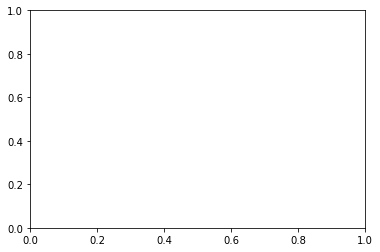

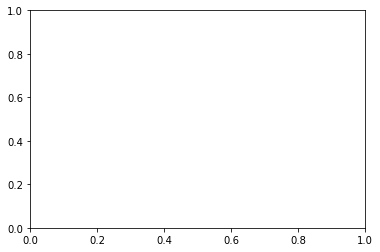

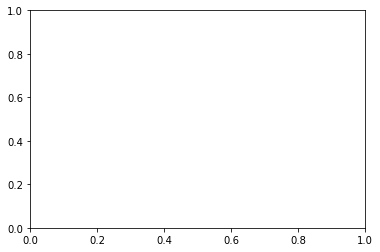

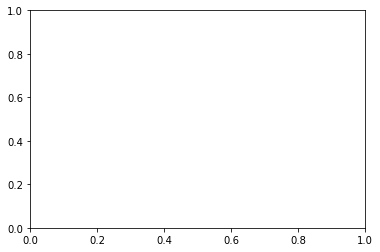

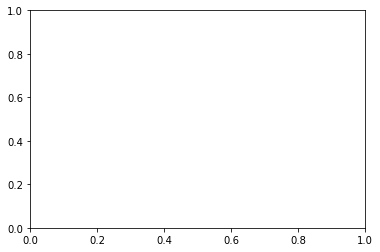

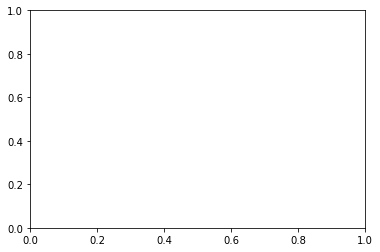

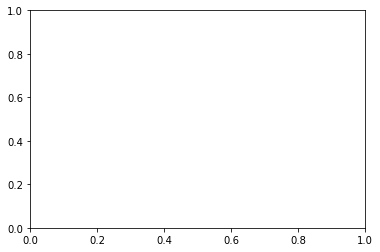

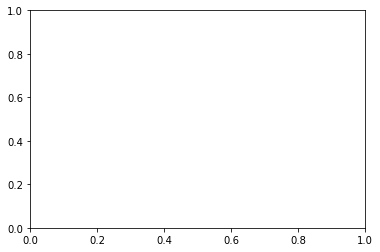

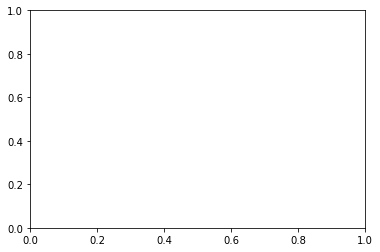

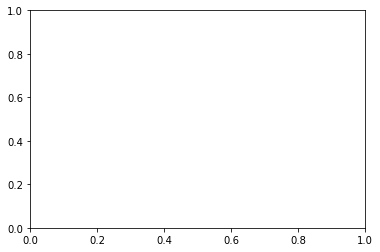

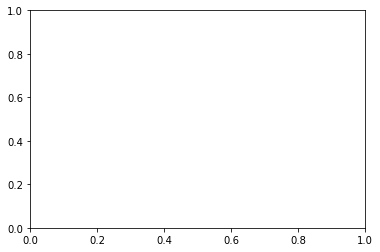

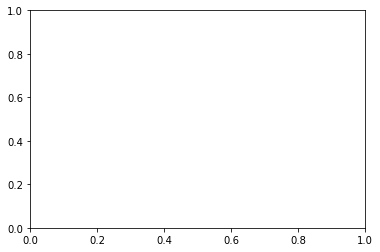

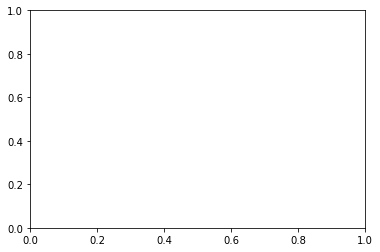

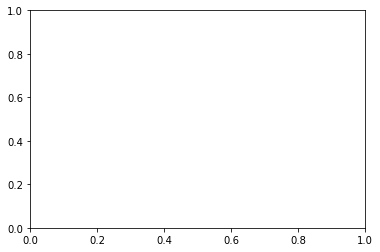

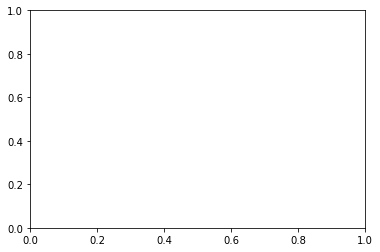

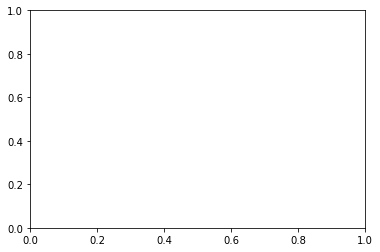

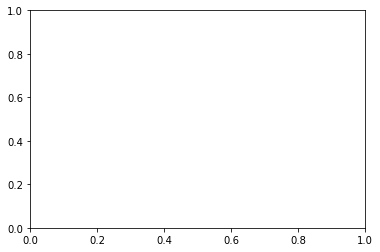

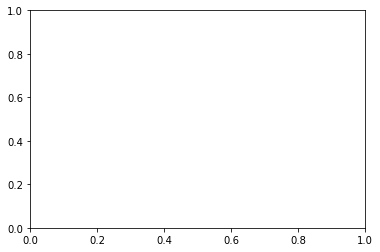

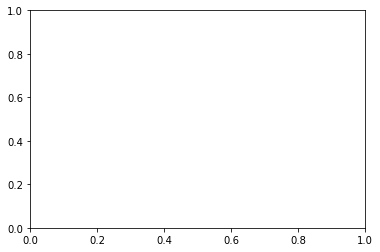

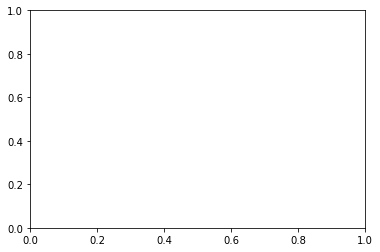

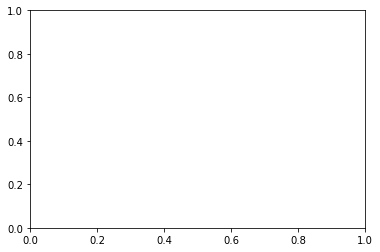

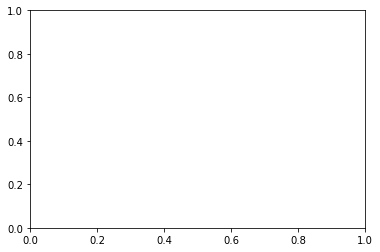

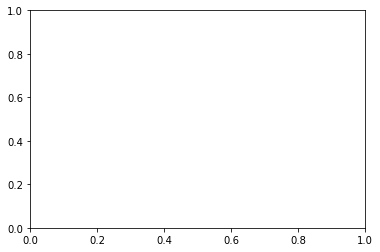

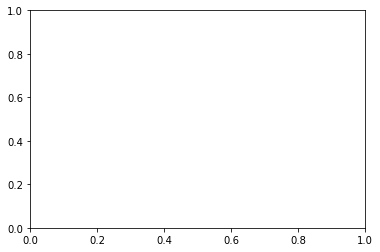

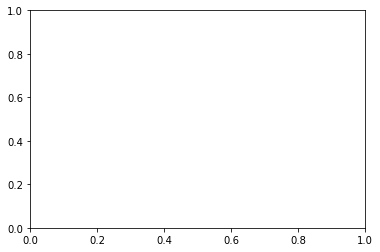

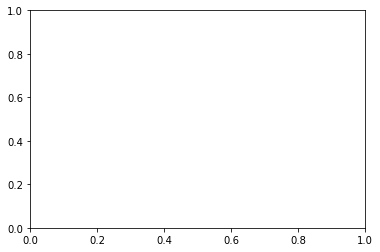

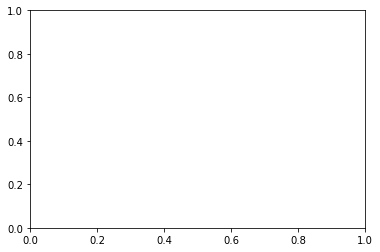

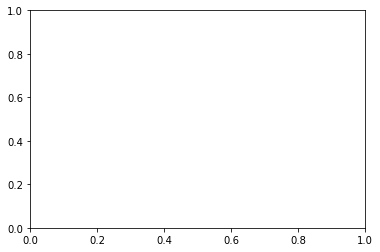

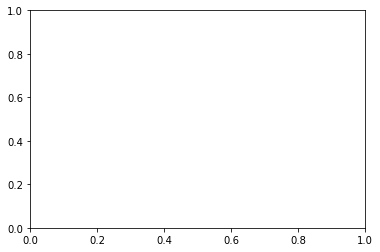

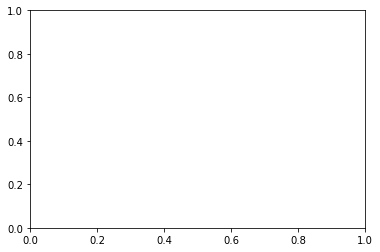

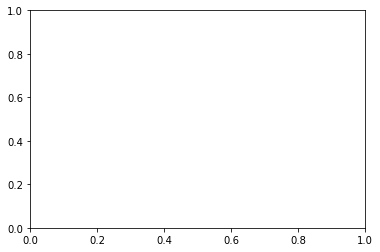

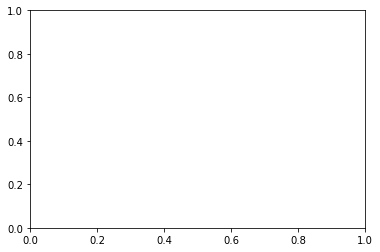

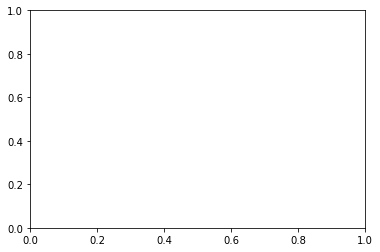

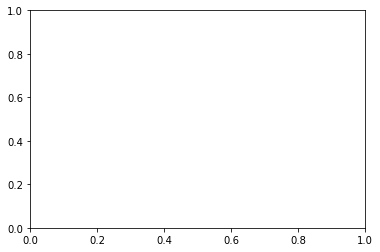

In [19]:
#Open Street Map
import osmnx as ox

#Set backdrop
graph = ox.graph_from_point((2.9252, 101.6484), distance=2000)
nodes, edges = ox.graph_to_gdfs(graph)
area = ox.gdf_from_place("Cyberjaya")
cmap = plt.get_cmap('Oranges',10)


for row, minute in enumerate(sorted(list(df_filtered['date_time2'].unique()))):
    # Plot the backdrop
    fig, (ax) = plt.subplots()
    ax = area.plot(facecolor='white', figsize=(10,10))
    GeoSeries(shape[shape.grid_id.isin(route1)].iloc[:,1]).plot(ax=ax,color='white',alpha=0.6, markersize=0)


    # Plot street edges
    edges.plot(ax=ax, linewidth=1, edgecolor='#BC8F8F')
    plt.title('Cyberjaya Road Grid Static Subscriber By Minute')
    plt.xlabel(str(minute)[0:10]+'           '+str(minute)[11:16])
    
    #Plot static customer id on each grid for each time frame
    static_data=df_static[df_static['date_time2']==minute]
    
    # Loop over all the grid_id in each of the six routes. 
    for i,grid in enumerate(route1+route2+route3+route4+route5+route6):
        static_count=static_data[static_data['grid_id']==grid]['count']
        
        GeoSeries(shape[shape.grid_id==grid].iloc[:,1]).plot(ax=ax,color=cm.Oranges(static_count/15),alpha=0.9)
    
    #Add colorbar for easy reference
    norm=mpl.colors.Normalize(vmin=0,vmax=15)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar=mpl.colorbar.ColorbarBase(cax,cmap=cmap,norm=norm,orientation='vertical')    
    #Save each frame to file. 
    plt.savefig('gif%d'%row)
    plt.close()

## All the frame files are converted to gif using external software 

In [ ]:
from IPython.display import Image
Image(url='/Static_Gif/Static_gif.gif')  